EX1: The n-dimensional tensor mastery challenge: Combine the `Head` and `MultiHeadAttention` into one class that processes all the heads in parallel, treating the heads as another batch dimension (answer is in nanoGPT).

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Pulling in our code from lecture, we left off with the following implementation:

In [2]:
class SelfAttentionHead(nn.Module):
    def __init__(self, input_channels, output_channels, context_length, dropout=0.05) -> None:
        super().__init__()
        self.input_channels = input_channels
        self.output_channels = output_channels
        self.key = nn.Linear(input_channels, output_channels, bias=False)
        self.query = nn.Linear(input_channels, output_channels, bias=False)
        self.value = nn.Linear(input_channels, output_channels, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones((context_length, context_length))))
        self.dropout = nn.Dropout(dropout)
        
        
    def forward(self, idx):
        B, T, C = idx.shape
        
        # lookup query, key, and value vectors
        # C == input_channels, H == output_channels == head_size
        k = self.key(idx) # (B, T, C) -> (B, T, H)
        q = self.query(idx) # (B, T, C) -> (B, T, H)
        v = self.value(idx) # (B, T, C) -> (B, T, H)

        # compute self attention by taking dot product of query and key
        wei = q @ k.transpose(-2, -1) # (B, T, H) @ (B, H, T) -> (B, T, T)

        wei *= self.output_channels ** -0.5 # scale by sqrt of head size
        
        # apply lower triangular mask to weights
        wei = wei.masked_fill(self.tril[:T,:T]==0, float('-inf')) # (B, T, T)

        # apply softmax to get attention weights
        wei = F.softmax(wei, dim=-1) # (B, T, T)

        wei = self.dropout(wei) # (B, T, T)

        # apply attention weights to values
        out = wei @ v # (B, T, T) @ (B, T, H) -> (B, T, H)

        return out # (B, T, H)
    

class FeedForward(nn.Module):
    def __init__(self, input_channels, output_channels) -> None:
        super().__init__()

        self.ff = nn.Sequential(
            nn.Linear(input_channels, output_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.ff(x)

class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size, context_length, head_size, num_heads) -> None:
        super().__init__()

        self.heads = nn.ModuleList([
            SelfAttentionHead(emb_size, head_size, context_length) for _ in range(num_heads)
        ])

    def forward(self, x):
        return torch.cat([head(x) for head in self.heads], dim=-1)
    

class ResidualTransformerBlock(nn.Module):
    def __init__(self, emb_size, head_size, context_length, num_multi_attn_heads) -> None:
        super().__init__()
        self.attn = MultiHeadAttention(emb_size, context_length, head_size//num_multi_attn_heads, num_heads=num_multi_attn_heads)
        self.ff = FeedForward(head_size, head_size)
        self.norm1 = nn.LayerNorm(head_size)
        self.norm2 = nn.LayerNorm(head_size)

    def forward(self, x):
        x = self.attn(self.norm1(x)) + x # residual
        x = self.ff(self.norm2(x)) + x # residual
        return x
    
class MultiBlockModel(nn.Module):
    def __init__(self, vocab_size, emb_size, head_size, context_length, num_multi_attn_heads, num_blocks) -> None:
        super().__init__()
        assert head_size % num_multi_attn_heads == 0
        self.token_embeddings = nn.Embedding(vocab_size, emb_size)
        self.positional_embeddings = nn.Embedding(context_length, emb_size)
        self.blocks = nn.Sequential(*[ResidualTransformerBlock(emb_size, head_size, context_length, num_multi_attn_heads) for _ in range(num_blocks)], nn.LayerNorm(head_size))
        self.ff = FeedForward(head_size, head_size)
        self.output_layer = nn.Linear(head_size, vocab_size)

        self.context_length = context_length

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # get token and positional embeddings
        t = self.token_embeddings(idx) # (B, T) -> (B, T, C)
        p = self.positional_embeddings(torch.arange(T, device=idx.device)) # (T, C)
        x = t + p # (B, T, C) (broadcasting)

        # pass thru attention head
        x = self.blocks(x) # (B, T, C) -> (B, T, H)
        
        # pass thru feed forward
        x = self.ff(x) # (B, T, H) -> (B, T, H)

        # pass thru output layer
        logits = self.output_layer(x) # (B, T, H) -> (B, T, V)

        
        if targets is not None:
            B, T, V = logits.shape
            logits = logits.view(B*T, V)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)
        else:
            loss = None

        return logits, loss
    
    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            idx_crop = idx[:,-self.context_length:]
            logits, _ = self(idx_crop)
            logits = logits[:,-1,:] # all batches, last timestamp, all channels
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx


In lecture we implemented multi-head attention by feeding data into several different 'Head' modules in series and then concating the results. We can implement a vectorized version by combining the linear layers of each head into unified linear layers. We just need to be sure to get the dimensions correctly matched up, so that when we create a dimension for each head prior to computing the query-key dot product. I've outlined the shapes of each intermediate tensor in comments.

In [3]:
class MultiHeadAttention(nn.Module):
    def __init__(self, input_channels, output_channels, context_length, num_heads, dropout=0.05) -> None:
        assert output_channels % num_heads == 0
        super().__init__()
        self.input_channels = input_channels
        self.output_channels = output_channels
        self.head_size = output_channels // num_heads
        self.num_heads = num_heads
        self.key = nn.Linear(input_channels, output_channels, bias=False)
        self.query = nn.Linear(input_channels, output_channels, bias=False)
        self.value = nn.Linear(input_channels, output_channels, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones((context_length, context_length))))
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, idx):
        B, T, C = idx.shape 
        # B = batches
        # T = timesteps
        # C = input channels
        # Nh = attention heads
        # Hs = head size
        
        q = self.query(idx) # (B, T, C) -> (B, T, Nh * Hs)
        k = self.key(idx) # (B, T, C) -> (B, T, Nh * Hs)
        
        q = q.transpose(-2, -1).view(B, self.num_heads, self.head_size, T).transpose(-2, -1) # (B, T, Nh * Hs) -> (B, Nh, T, Hs)
        k = k.transpose(-2, -1).view(B, self.num_heads, self.head_size, T) # (B, T, Nh * Hs) -> (B, Nh, Hs, T)
        
        w = q @ k # (B, Nh, T, Hs) @ (B, Nh, Hs, T) -> (B, Nh, T, T)
        w = w.masked_fill(self.tril[:T,:T] == 0, float('-inf'))

        w *= self.head_size**-0.5
        w = F.softmax(w, dim=-1)

        w = self.dropout(w)
        
        v = self.value(idx) # (B, T, C) -> (B, T, Nh * Hs)
        v = v.transpose(-2, -1).view(B, self.num_heads, self.head_size, T).transpose(-2, -1) # (B, T, Nh * Hs) -> (B, Nh, T, Hs)

        # torch requires a reshape here for reasons I don't fully understand
        attn_out = (w @ v).transpose(-3, -2).reshape(B, T, -1)

        return attn_out
    

# Need to redifine classes that use MultiHeadAttention as well!

class ResidualTransformerBlock(nn.Module):
    def __init__(self, emb_size, head_size, context_length, num_multi_attn_heads) -> None:
        super().__init__()
        self.attn = MultiHeadAttention(emb_size, head_size, context_length, num_heads=num_multi_attn_heads)
        self.ff = FeedForward(head_size, head_size)
        self.norm1 = nn.LayerNorm(head_size)
        self.norm2 = nn.LayerNorm(head_size)

    def forward(self, x):
        x = self.attn(self.norm1(x)) + x # residual
        x = self.ff(self.norm2(x)) + x # residual
        return x
    
class MultiBlockModel(nn.Module):
    def __init__(self, vocab_size, emb_size, head_size, context_length, num_multi_attn_heads, num_blocks) -> None:
        super().__init__()
        assert head_size % num_multi_attn_heads == 0
        self.token_embeddings = nn.Embedding(vocab_size, emb_size)
        self.positional_embeddings = nn.Embedding(context_length, emb_size)
        self.blocks = nn.Sequential(*[ResidualTransformerBlock(emb_size, head_size, context_length, num_multi_attn_heads) for _ in range(num_blocks)], nn.LayerNorm(head_size))
        self.ff = FeedForward(head_size, head_size)
        self.output_layer = nn.Linear(head_size, vocab_size)

        self.context_length = context_length

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # get token and positional embeddings
        t = self.token_embeddings(idx) # (B, T) -> (B, T, C)
        p = self.positional_embeddings(torch.arange(T, device=idx.device)) # (T, C)
        x = t + p # (B, T, C) (broadcasting)

        # pass thru attention head
        x = self.blocks(x) # (B, T, C) -> (B, T, H)
        
        # pass thru feed forward
        x = self.ff(x) # (B, T, H) -> (B, T, H)

        # pass thru output layer
        logits = self.output_layer(x) # (B, T, H) -> (B, T, V)

        
        if targets is not None:
            B, T, V = logits.shape
            logits = logits.view(B*T, V)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)
        else:
            loss = None

        return logits, loss
    
    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            idx_crop = idx[:,-self.context_length:]
            logits, _ = self(idx_crop)
            logits = logits[:,-1,:] # all batches, last timestamp, all channels
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx


Now we can try training a model using this new component. If done correctly we should receive nearly identical results when compared to those from the lecture notebook, as the underlying structure of the network should not be fundamentally different and none of the hyperparameters have otherwise changed. 

First I'll pull in the all the training utility code:

In [4]:
import string

chars = sorted(list(set(string.printable)))
vocab_size = len(chars) + 1

stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
stoi['ukn'] = len(stoi)
itos[len(itos)] = 'ukn'


encode = lambda s: [stoi.get(c, stoi['ukn']) for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

data = torch.tensor(encode(text), dtype=torch.long, device=device)

spl = int(0.9 * len(data))

train_data = data[:spl]

val_data = data[spl:]

torch.manual_seed(1337)

batch_size = 4
context_length = 8

def get_batch(split, batch_size, context_length):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - context_length, (batch_size,))
    x = torch.stack([data[i:i+context_length] for i in ix])
    y = torch.stack([data[i+1:i+context_length+1] for i in ix])
    return x, y

def evaluate(model, batch_size, context_length, num_batches = 100):
    model.eval()
    x, y = get_batch('val', batch_size, context_length)
    losses = []
    for _ in range(num_batches):
        _, loss = model(x, y)
        losses.append(loss.item())
    loss = np.mean(losses)
    model.train()
    return loss


def train(model, num_steps, batch_size, context_length, learning_rate=1e-3, optimizer=None, print_every=1000, evaluate_every=1000):
    if optimizer is None:
        optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    model.train()
    losses = []
    eval_losses = []
    for step in range(1, num_steps+1):
        optimizer.zero_grad()
        x, y = get_batch('train', batch_size, context_length)
        logits, loss = model(x, y)
        loss.backward()
        optimizer.step()
        if step % print_every == 0:
            print(f'step {step}: loss {loss.item()}')

        if step == 0 or step % evaluate_every == 0:
            eval_loss = evaluate(model, batch_size, context_length)
            eval_losses.append(eval_loss)
        losses.append(loss.item())
    

    return losses, eval_losses

def plot_ema(losses, eval_losses, gamma=0.99, title='ema'):
    ema = losses[0]
    ema_losses = []
    eval_indices = np.linspace(0, len(losses), len(eval_losses), dtype=int)
    for i, l in enumerate(losses):
        ema = gamma * ema + (1-gamma) * l
        ema_losses.append(ema)
    plt.plot(ema_losses, label='train', color='red')
    plt.plot(eval_indices, eval_losses, label='val', color='blue')
    plt.legend()
    plt.show()
    print('final train loss (ema):', ema_losses[-1])
    print('final validation loss:', eval_losses[-1])

def generate_text(model, starting_text=None, max_new_tokens=100):
    if starting_text is None:
        starting_text = ''
        data = torch.zeros((1, 1), dtype=torch.long, device=device)
    else:
        data = torch.tensor(encode(starting_text), dtype=torch.long, device=device).reshape(-1, 1)
    model.eval()
    with torch.no_grad():
        print(starting_text + decode(model.generate(data, max_new_tokens=max_new_tokens)[-1].tolist()))
    model.train()

Now we can train the new model with identical parameters to the last training run from lecture:

step 1000: loss 2.102978229522705
step 2000: loss 1.8773711919784546
step 3000: loss 1.755046010017395
step 4000: loss 1.69569993019104
step 5000: loss 1.686732292175293
step 6000: loss 1.5767172574996948
step 7000: loss 1.5750452280044556
step 8000: loss 1.5459606647491455
step 9000: loss 1.5760196447372437
step 10000: loss 1.566866397857666


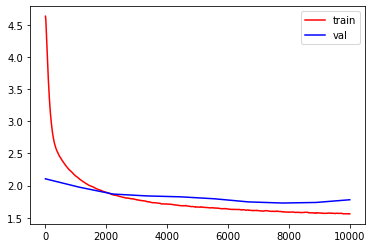

final train loss (ema): 1.5604387851971326
final validation loss: 1.7794170379638672


1.7175747156143188

In [5]:
context_length = 128
batch_size = 32
emb_size = 64
multi_block_model = MultiBlockModel(vocab_size, emb_size, emb_size, context_length, num_multi_attn_heads=8, num_blocks=8).to(device)
losses, eval_losses = train(multi_block_model, 10000, batch_size, context_length)
plot_ema(losses, eval_losses)

With a loss of ~1.56, our results are almost exactly the same as before, which means our implementation should be correct. This new implementation computes the entire multi-head attention layer in a vectorized manner rather than concatenating results from self-attention heads in series.

In [6]:
generate_text(multi_block_model, None, 1000)

	ir water's blower-with word of the you.

Second Norby, so nece sware consulferooks
And cappite joy, bable us made beserve eance
Will me impts and fouth trift. Cowidon, all I care: I fie,
To readge, me breath.

KING HENRY VI:
No, make were consinged in Maniaghtes:
And a threforines head, sprop my mighty
The rest all be hightly us' meath,
And, Clebmothy and in his such from shapperlious
A knight duty uc, hath he streng the conptient.

Get thou of mine myseln greess? Well,
The gree--Richbard, your afforth faced Lances
Thou yech are mid exteranchs to made knock.
And this cive dies did boy new thy say,
All bews in this dight-prof times of recomanious?
I know your art to his beitanating to their belle.
O bromes him had cold perforges live,
It my lest duty may, when that of vage head,
'Ren boons: the that kingly throus harm father
laight a he daughterting else keeep falle beeen
and the has apinty chafe me appersh'd,
Till these by son
In must with him. Vinale and you, I sacions is:
Thou this,

EX2: Train the GPT on your own dataset of choice! What other data could be fun to blabber on about? (A fun advanced suggestion if you like: train a GPT to do addition of two numbers, i.e. a+b=c. You may find it helpful to predict the digits of c in reverse order, as the typical addition algorithm (that you're hoping it learns) would proceed right to left too. You may want to modify the data loader to simply serve random problems and skip the generation of train.bin, val.bin. You may want to mask out the loss at the input positions of a+b that just specify the problem using y=-1 in the targets (see CrossEntropyLoss ignore_index). Does your Transformer learn to add? Once you have this, swole doge project: build a calculator clone in GPT, for all of +-*/. Not an easy problem. You may need Chain of Thought traces.)

We can use the huggingface datasets library to easily access and choose from amongst a large collection of nlp datasets. For this exercise, I've chosen to use the 'cnn_dailymail' dataset, which is comrpised of online news articles.

This dataset is also already split into a train and validation set, which is nice.

In [7]:
from datasets import load_dataset

data = load_dataset("ccdv/cnn_dailymail", "1.0.0")
train_data = data['train']
val_data = data['validation']


/home/ubuntu/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
Found cached dataset cnn_dailymail (/home/ubuntu/.cache/huggingface/datasets/ccdv___cnn_dailymail/1.0.0/1.0.0/0107f7388b5c6fae455a5661bcd134fc22da53ea75852027040d8d1e997f101f)


  0%|          | 0/3 [00:00<?, ?it/s]

We'll need to write a new get_batch function, since it would be a bit cumbersome to load the entire dataset into a single tensor. Instead, we can access an article at random, and then pull out a random subsection of text from within that article.

In [8]:
def get_batch(split, batch_size, context_length):
    data = train_data if split == 'train' else val_data
    ix1 = torch.randint(len(data), (batch_size,))
    
    articles = [data[i.item()]['article'] for i in ix1]
    encoded_articles = [encode(a) for a in articles]
    tokenized_articles = torch.tensor([encoding for article in encoded_articles for encoding in article], dtype=torch.long, device=device)
    ix2 = torch.randint(len(tokenized_articles) - context_length, (batch_size,))
    x = torch.stack([tokenized_articles[i:i+context_length] for i in ix2])
    y = torch.stack([tokenized_articles[i+1:i+context_length+1] for i in ix2])
    return x, y

Then, we can train the model just the same as before. Since the dataset is a bit larger we'll train for twice as many steps.

step 1000: loss 2.1318159103393555
step 2000: loss 1.886654257774353
step 3000: loss 1.780901551246643
step 4000: loss 1.697569727897644
step 5000: loss 1.755009412765503
step 6000: loss 1.643255352973938
step 7000: loss 1.556833267211914
step 8000: loss 1.6296324729919434
step 9000: loss 1.5706883668899536
step 10000: loss 1.5679899454116821
step 11000: loss 1.604675531387329
step 12000: loss 1.5732502937316895
step 13000: loss 1.5478116273880005
step 14000: loss 1.518553614616394
step 15000: loss 1.5375080108642578
step 16000: loss 1.5100337266921997
step 17000: loss 1.514094352722168
step 18000: loss 1.428208589553833
step 19000: loss 1.5041663646697998
step 20000: loss 1.4818570613861084


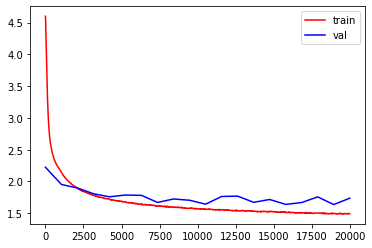

final train loss (ema): 1.491172840211055
final validation loss: 1.7365468740463257


In [22]:
context_length = 128
batch_size = 32
emb_size = 64
multi_block_model = MultiBlockModel(vocab_size, emb_size, emb_size, context_length, num_multi_attn_heads=8, num_blocks=8).to(device)
losses, eval_losses = train(multi_block_model, 20000, batch_size, context_length)
plot_ema(losses, eval_losses)

Our model still overfits a bit here, but our output doesn't look half bad. It's still nonsense but sounds newsy-like.

In [10]:
generate_text(multi_block_model, None, 1000)

	rring has for people. He her asked polege, Internaties more than .,34,020 yearloas and Crisse. Builbams have last end medile-man export from by Aitter Csst Kaail Novembeers and Quobd this firster and towness of the Prans off Avabuas made 12,000 in NutchN. On Baterer 1, solders agreements intruges, uperson really exolue slinked the carlimment numbers tured: uknof haires politicy because if wantional abjoping in at nrim donate division. The Tans. They fushing from specive time his.  The ashives.ukn How is is a one of Edfield said donuknt is with a diard is treated. 'Then it's numberly (24,000 yantio. "Nida EAWG:2 Zirda Trea, their one-reports was we whan leal get to their police years wanted Uirgin, for these of the deal Protector Chnourt Hething's will knees, Gladely in 2012 which her hear overtured by pressents have been healthn. Mondoye Bruem, old in the ditival to mobition will said whe three have been his also show. Then Kriter conclection.' Nugteremiusdary Mrstandance Pissign to s

EX3: Find a dataset that is very large, so large that you can't see a gap between train and val loss. Pretrain the transformer on this data, then initialize with that model and finetune it on tiny shakespeare with a smaller number of steps and lower learning rate. Can you obtain a lower validation loss by the use of pretraining?

We'll try to fine-tune the news model for shakespeare. It had a bit of a gap between train and validation loss but is still much larger than the shakespeare corpus.

In [24]:
data = torch.tensor(encode(text), dtype=torch.long, device=device)

spl = int(0.9 * len(data))

train_data = data[:spl]

val_data = data[spl:]

def get_batch(split, batch_size, context_length):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - context_length, (batch_size,))
    x = torch.stack([data[i:i+context_length] for i in ix])
    y = torch.stack([data[i+1:i+context_length+1] for i in ix])
    return x, y

For fine-tuning we need to choose which portions of the model we want to freeze, and which paramters we want to allow to be learned. I'll freeze the first 4 multi-head attention blocks by setting required_grad to be False, and allow the rest of the paramters to be optimized.

In [25]:
from copy import deepcopy

finetuned_model = deepcopy(multi_block_model)

In [26]:
for block in finetuned_model.blocks[4:]:
    for p in block.parameters():
        p.requires_grad = False

step 1000: loss 1.4440546035766602
step 2000: loss 1.4285008907318115
step 3000: loss 1.5048296451568604
step 4000: loss 1.4297479391098022
step 5000: loss 1.5016945600509644


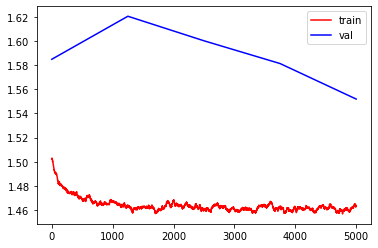

final train loss (ema): 1.4639546850904759
final validation loss: 1.5518561601638794


In [27]:
losses, eval_losses = train(finetuned_model, 5000, batch_size, context_length, 1e-4)
plot_ema(losses, eval_losses)

This seemed to work pretty well! We achieved a lower final validation loss than we did before -- and the train loss started at around 1.5, which is much lower than if we would have started from scratch. We were even able to improve further on the training loss by fine-tuning the non-frozen parameters.

In [29]:
generate_text(finetuned_model, None, 1000)

	 three and do purncer you gentleman:
Steal it be Aover obes? Peace this voice
Har still had staughters and fly to weep to my
To will bapegn? Has shore a nature to be dukele
Their to-nife in traitls giils is one:
We shall fellow once the bloodl of the poor's wash awas:
to do fees, land and not nokens
power crown the vice at ever affirm'd but dand.

Apoloy;
Wife, pless and might thou to strike thy trook
Daties nother those too news, deing are war flame
To anvoides me I say our long tone out,
Madane he serve call and even as desperation,
Shall this murder sinces absward.

SABHON:
For all, you warlikess!

ROMEO:
For you:
Why sweett, he'll my uncle.

CORIOLANUS:
Take you rate-run.

BRUTUS:
Here judge, that have my home
Thate wash of that sinly, with remert in the solding prize
find kineven white; each occutaus brawded,
And Oxperhall no the fearing as that adverct-out
In thew hehore mine her her devom him:
Mark me, no country, trains.

SICINIUS:
Ad move my lord brow eyes,
That spreaden, hav

Sanity check: this indeed looks like shakespeare!

EX4: Read some transformer papers and implement one additional feature or change that people seem to use. Does it improve the performance of your GPT?

For this exercise I'll be implementing the LazyFormer architecture (https://arxiv.org/pdf/2102.12702.pdf)

This architecture aims to reduce computation requirements by only calculating the key and query matrices once, and re-using them within a sequential block of *m* self-attention modules. 

To implement this, we can first implement a *LazyMultiHeadAttention* block, which is just the multi-head attention block we've implemented before minus the key and query dot product, we just pass that as a second argument called *softmax output*.

In [ ]:
class LazyMultiHeadAttention(nn.Module):
    def __init__(self, input_channels, output_channels, context_length, num_heads, dropout=0.05) -> None:
        assert output_channels % num_heads == 0
        super().__init__()
        self.input_channels = input_channels
        self.output_channels = output_channels
        self.head_size = output_channels // num_heads
        self.num_heads = num_heads
        self.value = nn.Linear(input_channels, output_channels, bias=False)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, inputs):
        idx, kq = inputs
        B, T, C = idx.shape 
    
        w = self.dropout(kq)
        v = self.value(idx) # (B, T, C) -> (B, T, Nh * Hs)
        v = v.transpose(-2, -1).view(B, self.num_heads, self.head_size, T).transpose(-2, -1) # (B, T, Nh * Hs) -> (B, Nh, T, Hs)

        # torch requires a reshape here for reasons I don't fully understand
        attn_out = (w @ v).transpose(-3, -2).reshape(B, T, -1)

        return attn_out

Then, we can implement the KQ dot-product as its own block, then pass this result through each of the lazy blocks by simply returning it again.

In [ ]:
class LazyKQ(nn.Module):
    def __init__(self, input_channels, output_channels, context_length, num_heads):
        super().__init__()
        self.head_size = output_channels // num_heads
        self.num_heads = num_heads
        self.register_buffer('tril', torch.tril(torch.ones((context_length, context_length))))
        self.key = nn.Linear(input_channels, output_channels, bias=False)
        self.query = nn.Linear(input_channels, output_channels, bias=False)
        
    def forward(self, idx):
        B, T, C = idx.shape 
        # B = batches
        # T = timesteps
        # C = input channels
        # Nh = attention heads
        # Hs = head size
        
        q = self.query(idx) # (B, T, C) -> (B, T, Nh * Hs)
        k = self.key(idx) # (B, T, C) -> (B, T, Nh * Hs)
        
        q = q.transpose(-2, -1).view(B, self.num_heads, self.head_size, T).transpose(-2, -1) # (B, T, Nh * Hs) -> (B, Nh, T, Hs)
        k = k.transpose(-2, -1).view(B, self.num_heads, self.head_size, T) # (B, T, Nh * Hs) -> (B, Nh, Hs, T)
        
        w = q @ k # (B, Nh, T, Hs) @ (B, Nh, Hs, T) -> (B, Nh, T, T)
        w = w.masked_fill(self.tril[:T,:T] == 0, float('-inf'))

        w *= self.head_size**-0.5
        w = F.softmax(w, dim=-1)
        
        return w
    
class LazyFormerInnerBlock(nn.Module):
    def __init__(self, emb_size, head_size, context_length, num_multi_attn_heads) -> None:
        super().__init__()
        self.attn = LazyMultiHeadAttention(emb_size, head_size, context_length, num_heads=num_multi_attn_heads)
        self.ff = FeedForward(head_size, head_size)
        self.norm1 = nn.LayerNorm(head_size)
        self.norm2 = nn.LayerNorm(head_size)

    def forward(self, inputs):
        x, kq = inputs
        x = self.attn((self.norm1(x), kq)) + x # residual
        x = self.ff(self.norm2(x)) + x # residual
        return (x, kq)

This bundles nicely together into a higher-level module:

In [ ]:
class LazyFormerBlock(nn.Module):
    def __init__(self, m, input_channels, output_channels, context_length, num_heads):
        super().__init__()
        self.lazyblocks = nn.Sequential(
            *[LazyFormerInnerBlock(input_channels, output_channels, context_length, num_heads) for _ in range(m)] 
        )
        
        self.lazy_kq = LazyKQ(input_channels, output_channels, context_length, num_heads)
    
    def forward(self, x):
        (res, _) = self.lazyblocks((x, self.lazy_kq(x)))
        return res
    
    
class LazeFormerModel(nn.Module):
    def __init__(self, vocab_size, emb_size, head_size, context_length, num_multi_attn_heads, num_blocks, m) -> None:
        super().__init__()
        assert head_size % num_multi_attn_heads == 0
        self.token_embeddings = nn.Embedding(vocab_size, emb_size)
        self.positional_embeddings = nn.Embedding(context_length, emb_size)
        self.blocks = nn.Sequential(*[LazyFormerBlock(m, emb_size, head_size, context_length, num_multi_attn_heads) for _ in range(num_blocks)], nn.LayerNorm(head_size))
        self.ff = FeedForward(head_size, head_size)
        self.output_layer = nn.Linear(head_size, vocab_size)

        self.context_length = context_length

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # get token and positional embeddings
        t = self.token_embeddings(idx) # (B, T) -> (B, T, C)
        p = self.positional_embeddings(torch.arange(T, device=idx.device)) # (T, C)
        x = t + p # (B, T, C) (broadcasting)

        # pass thru attention head
        x = self.blocks(x) # (B, T, C) -> (B, T, H)
        
        # pass thru feed forward
        x = self.ff(x) # (B, T, H) -> (B, T, H)

        # pass thru output layer
        logits = self.output_layer(x) # (B, T, H) -> (B, T, V)

        
        if targets is not None:
            B, T, V = logits.shape
            logits = logits.view(B*T, V)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)
        else:
            loss = None

        return logits, loss
    
    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            idx_crop = idx[:,-self.context_length:]
            logits, _ = self(idx_crop)
            logits = logits[:,-1,:] # all batches, last timestamp, all channels
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx

    

The compute savings we get decreases our training time, so we can devote more resources towards scaling up our model if we choose to.

step 500: loss 2.222447633743286
step 1000: loss 1.9997532367706299
step 1500: loss 1.8058192729949951
step 2000: loss 1.7145823240280151
step 2500: loss 1.6224730014801025
step 3000: loss 1.5572205781936646
step 3500: loss 1.5780043601989746
step 4000: loss 1.565028190612793
step 4500: loss 1.4497921466827393
step 5000: loss 1.4408061504364014
step 5500: loss 1.513249158859253
step 6000: loss 1.4738184213638306
step 6500: loss 1.4893865585327148
step 7000: loss 1.4597078561782837
step 7500: loss 1.4414904117584229
step 8000: loss 1.401940107345581
step 8500: loss 1.4191604852676392
step 9000: loss 1.4558546543121338
step 9500: loss 1.3784352540969849
step 10000: loss 1.379726767539978
step 10500: loss 1.4191715717315674
step 11000: loss 1.3507015705108643
step 11500: loss 1.3854241371154785
step 12000: loss 1.390730619430542
step 12500: loss 1.34495210647583
step 13000: loss 1.405100703239441
step 13500: loss 1.378846287727356
step 14000: loss 1.33842134475708
step 14500: loss 1.41098

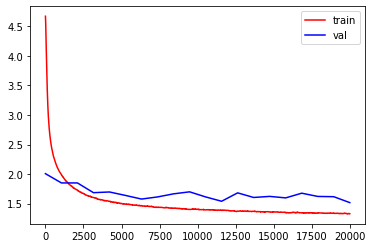

final train loss (ema): 1.329646972399085
final validation loss: 1.5169371366500854


In [ ]:
context_length = 128
batch_size = 32
emb_size = 64
m = 4
multi_block_model = LazeFormerModel(vocab_size, emb_size, emb_size, context_length, num_multi_attn_heads=8, num_blocks=8, m=m).to(device)
losses, eval_losses = train(multi_block_model, 20000, batch_size, context_length, print_every=500)
plot_ema(losses, eval_losses)

By applying this technique we were able to acheive an even lower validation loss!

In [ ]:
generate_text(multi_block_model, None, 1000)

	ly wearms upon, as if make the sdeep
And that she lives his person; by the norther lies.

EXETER:
Where I did not should would busing, better
Rogeo?

HERMIONE:
Not a voices
With go the sovereign, away, leaves his sir;
Do more fault Aptaticion: then he did.
It shall be a skarle Edward in thee.

MARCIUS:
Should I did not: I have lief to lay is;
So swain'd, as seen the rescront?

Shepherd:
But, gentle poor backs, if thou wert you,
Which many or sweetn, for, my face, to see foul
the queen his time vized passion
think you do not go vant of Armiliable.

HENRY BOLINGBROKE:
'Tis bacrike me but give me sphoming rough.

ROMEO:
Nay, night, and grat's thought.

MAMILLIUS:
Wilt not vame offends, Claudions of alred throng
of deservide.

WARWICK:
Come, cousin, I have rine
If you.

CORIOLANUS:
Which she is not
mother, after there, that men as officer.
Come, good crown, Marsa, or the gods,
As this king; and then most teapor plustity.

MENENIUS:
O, so rave hokses!
And no sovereign and which ever,
My si